# Performing a convergence study

This example shows how to perform a convergence study to find an appropriate
discretisation parameters for the Brillouin zone (`kgrid`) and kinetic energy
cutoff (`Ecut`), such that the simulation results are converged to a desired
accuracy tolerance.

In [1]:
using DFTK
using LinearAlgebra
using Statistics
using PseudoPotentialData

Such a convergence study is generally performed by starting with a
reasonable base line value for `kgrid` and `Ecut` and then increasing these
parameters (i.e. using finer discretisations) until a desired property (such
as the energy) changes less than the tolerance.

This procedure must be performed for each discretisation parameter. Beyond
the `Ecut` and the `kgrid` also convergence in the smearing temperature and
other numerical parameters should be checked. We will first discuss some guidelines
for default choices of these computational parameters and then provide an example
which shows how to converge `Ecut` and `kgrid` without looking at the other parameters
too much.

## Recommended default parameters

Providing general recommendations is difficult. Here, we follow the recent preprint
[arxiv 2504.03962](http://arxiv.org/abs/2504.03962v1) in suggesting **Fast**,
**Balanced** and **Stringent** protocols:
- **Fast** is meant for testing purposes and structure optimisations,
- **Balanced** for most practical applications and high-throughput settings,
- **Stringent** for cases where higher accuracy is needed.

Generally for insulators and metals **Balanced** is a good default option.
However, for **metals including lanthanide/actinide elements** the **Stringent**
protocol is recommended.

### Ecut

Standard pseudopotential libraries often already provide tabulated
recommendations for the kinetic energy cutoff `Ecut`, see Pseudopotentials.
This is the case for the common pseudodojo pseudopotentials, for example

In [2]:
family_upf = PseudoFamily("dojo.nc.sr.lda.v0_4_1.standard.upf")
recommended_cutoff(family_upf, :Si)

(Ecut = 16.0, supersampling = 2.0, Ecut_density = 64.0)

DFTK uses the recommended "normal" cutoff by default when constructing a `PlaneWaveBasis`.
For **Fast** and **Balanced** a `standard` pseudopotential, such as
`PseudoFamily("dojo.nc.sr.lda.v0_4_1.standard.upf")`, is generally fine,
but for **Stringent** a `stringent` pseudopotential, such as
`PseudoFamily("dojo.nc.sr.lda.v0_4_1.stringent.upf")` is recommended.

### Temperature and k-point grid

The study in [arxiv 2504.03962](http://arxiv.org/abs/2504.03962v1) focused on
`Smearing.MarzariVanderbilt` and resulted in the following recommended values.
For `k`-grid spacing we use the `KgridSpacing` struct, which can be passed
to the `PlaneWaveBasis` as `kgrid=KgridSpacing(0.08 )`, for example.

|     Protocol       |  Temperature (Hartree)    |   k-grid spacing (1/bohr)  |
| :----------------- | :-----------------------  | :------------------------: |
| Fast               | 0.01375                   | `KgridSpacing(0.106)`      |
| Balanced           | 0.01                      | `KgridSpacing(0.08 )`      |
| Stringent          | 0.00625                   | `KgridSpacing(0.053)`      |

We remark that for other first-order smearing schemes,
such as frist-order `Smearing.MethfesselPaxton`
the optimal values should be similar.

For `Smearing.Gaussian` (Gaussian smearing) one expects smaller optimal values
for the smearing temperature, while at the same time requiring finer $k$-point
meshes as well (smaller k-grid spacing). Finally, for `Smearing.FermiDirac`
we expect yet an even smaller optimal smearing temperature, related to the optimal
temperature of `Smearing.Gaussian` by `sqrt(2/3) * π` as discussed more in
[arxiv 2504.03962](http://arxiv.org/abs/2504.03962v1).


## Example: Bulk platinum
As the objective of this study we consider bulk platinum. For running the SCF
conveniently we define a function:

In [3]:
function run_scf(; a=5.0, Ecut, nkpt, tol)
    pseudopotentials = PseudoFamily("cp2k.nc.sr.lda.v0_1.largecore.gth")
    atoms    = [ElementPsp(:Pt, pseudopotentials)]
    position = [zeros(3)]
    lattice  = a * Matrix(I, 3, 3)

    model  = model_DFT(lattice, atoms, position;
                       functionals=LDA(), temperature=1e-2)
    basis  = PlaneWaveBasis(model; Ecut, kgrid=(nkpt, nkpt, nkpt))
    println("nkpt = $nkpt Ecut = $Ecut")
    self_consistent_field(basis; is_converged=ScfConvergenceEnergy(tol))
end;

Moreover we define some parameters. To make the calculations run fast for the
automatic generation of this documentation we target only a convergence to
1e-2. In practice smaller tolerances (and thus larger upper bounds for
`nkpts` and `Ecuts` are likely needed.

In [4]:
tol   = 1e-2      # Tolerance to which we target to converge
nkpts = 1:7       # K-point range checked for convergence
Ecuts = 10:2:24;  # Energy cutoff range checked for convergence

As the first step we converge in the number of $k$-points employed in each
dimension of the Brillouin zone …

In [5]:
function converge_kgrid(nkpts; Ecut, tol)
    energies = [run_scf(; nkpt, tol=tol/10, Ecut).energies.total for nkpt in nkpts]
    errors = abs.(energies[1:end-1] .- energies[end])
    iconv = findfirst(errors .< tol)
    (; nkpts=nkpts[1:end-1], errors, nkpt_conv=nkpts[iconv])
end
result = converge_kgrid(nkpts; Ecut=mean(Ecuts), tol)
nkpt_conv = result.nkpt_conv

nkpt = 1 Ecut = 17.0
n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime 
---   ---------------   ---------   ---------   ----   ------
  1   -26.49635359078                   -0.22    8.0    609ms
  2   -26.59228548258       -1.02       -0.63    2.0    237ms
  3   -26.61291154306       -1.69       -1.41    2.0   30.8ms
  4   -26.61326795287       -3.45       -2.14    2.0   30.3ms
nkpt = 2 Ecut = 17.0
n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime 
---   ---------------   ---------   ---------   ----   ------
  1   -25.79218159269                   -0.09    5.5   89.2ms
  2   -26.23295728372       -0.36       -0.70    2.0   62.0ms
  3   -26.23824233136       -2.28       -1.32    2.0   75.1ms
  4   -26.23848066279       -3.62       -2.31    1.0   54.3ms
nkpt = 3 Ecut = 17.0
n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime 
---   ---------------   ---------   ---------   ----   ------
  1   -25.78394019020                   -0.09    5.0   86.3ms
  2   -

5

… and plot the obtained convergence:

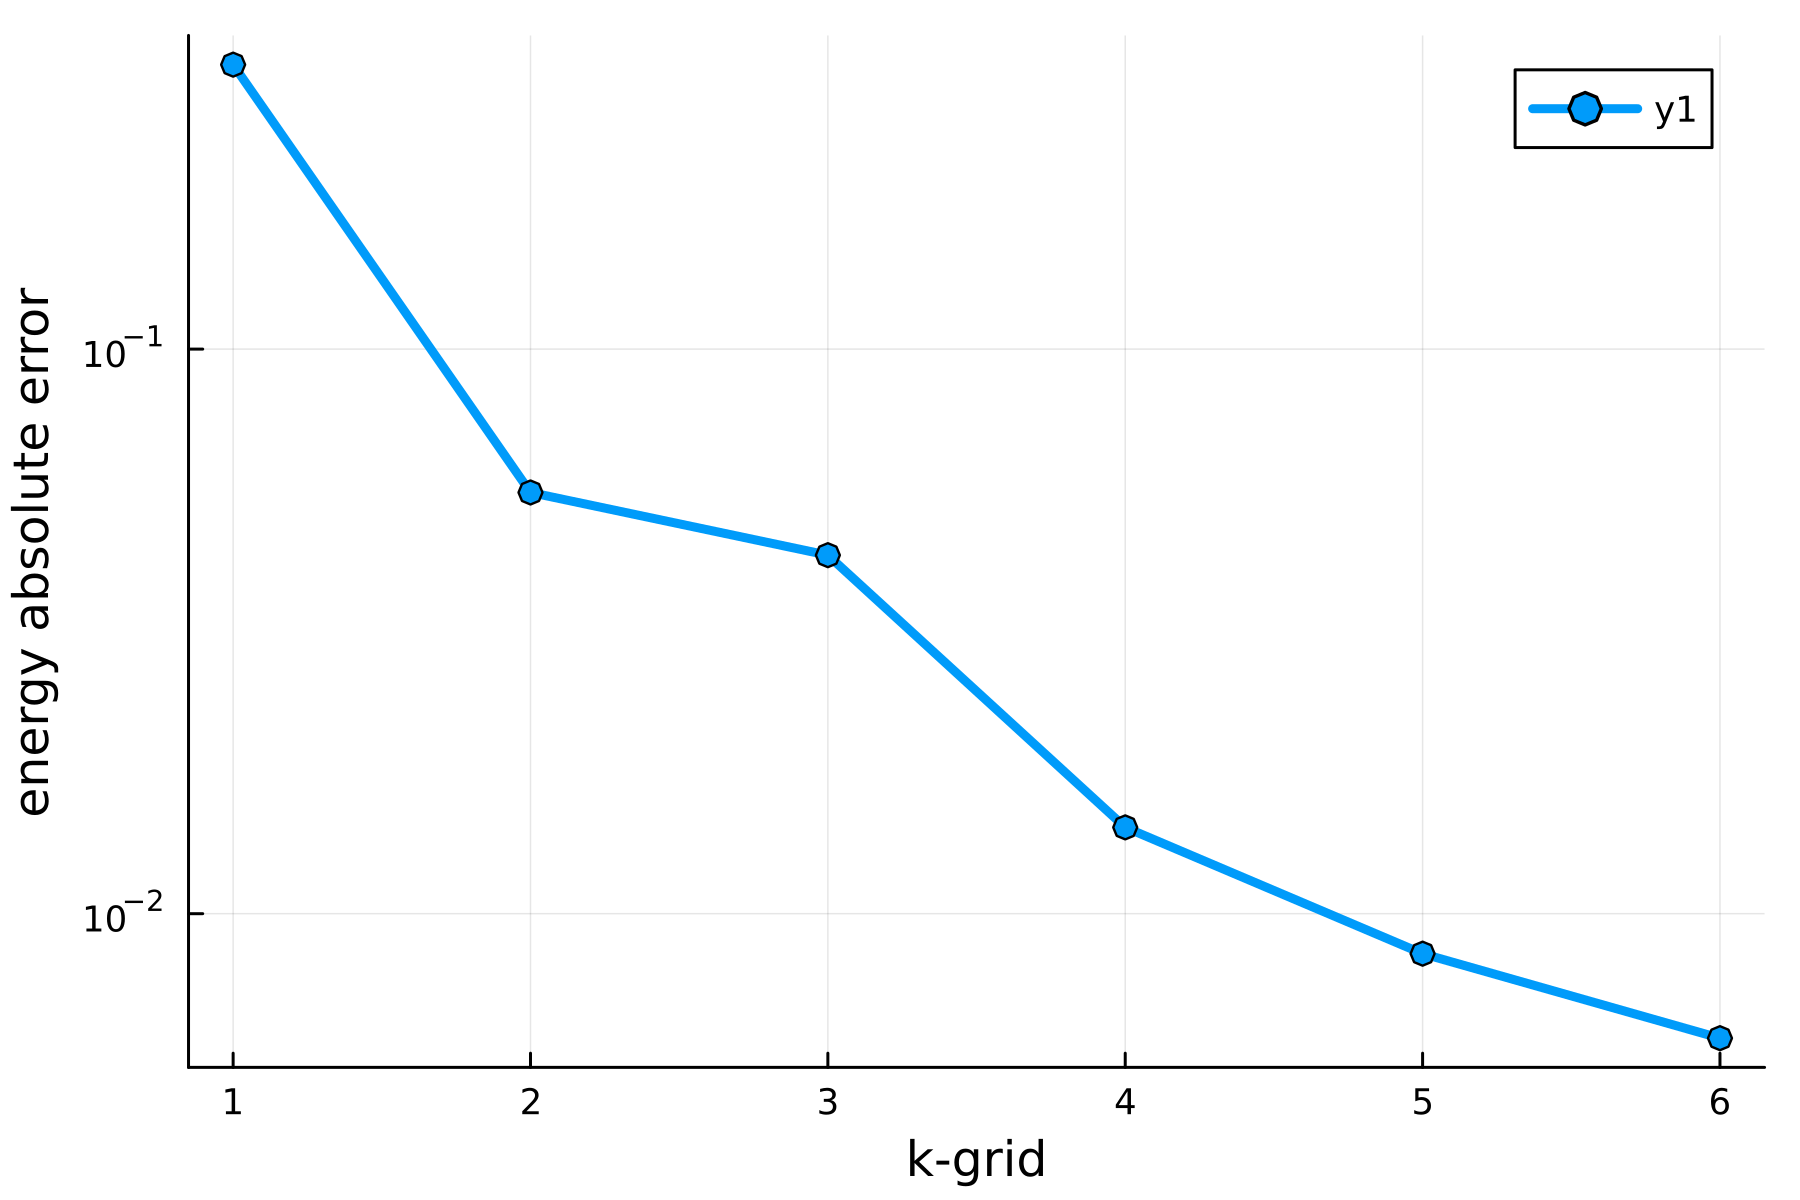

In [6]:
using Plots
plot(result.nkpts, result.errors, dpi=300, lw=3, m=:o, yaxis=:log,
     xlabel="k-grid", ylabel="energy absolute error")

We continue to do the convergence in Ecut using the suggested $k$-point grid.

In [7]:
function converge_Ecut(Ecuts; nkpt, tol)
    energies = [run_scf(; nkpt, tol=tol/100, Ecut).energies.total for Ecut in Ecuts]
    errors = abs.(energies[1:end-1] .- energies[end])
    iconv = findfirst(errors .< tol)
    (; Ecuts=Ecuts[1:end-1], errors, Ecut_conv=Ecuts[iconv])
end
result = converge_Ecut(Ecuts; nkpt=nkpt_conv, tol)
Ecut_conv = result.Ecut_conv

nkpt = 5 Ecut = 10
n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime 
---   ---------------   ---------   ---------   ----   ------
  1   -25.57864164446                   -0.16    3.8   69.4ms
  2   -25.77774683189       -0.70       -0.77    1.9   50.1ms
  3   -25.78626028492       -2.07       -1.84    2.0   55.5ms
  4   -25.78631682410       -4.25       -2.91    1.0   61.6ms
nkpt = 5 Ecut = 12
n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime 
---   ---------------   ---------   ---------   ----   ------
  1   -25.78656874501                   -0.12    3.5   69.8ms
  2   -26.07740727353       -0.54       -0.72    2.0   51.6ms
  3   -26.09341701240       -1.80       -1.68    2.2   59.2ms
  4   -26.09373753844       -3.49       -2.32    1.0   54.6ms
  5   -26.09375346907       -4.80       -2.70    1.0   41.3ms
nkpt = 5 Ecut = 14
n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime 
---   ---------------   ---------   ---------   ----   ------
  1   -25.868

18

… and plot it:

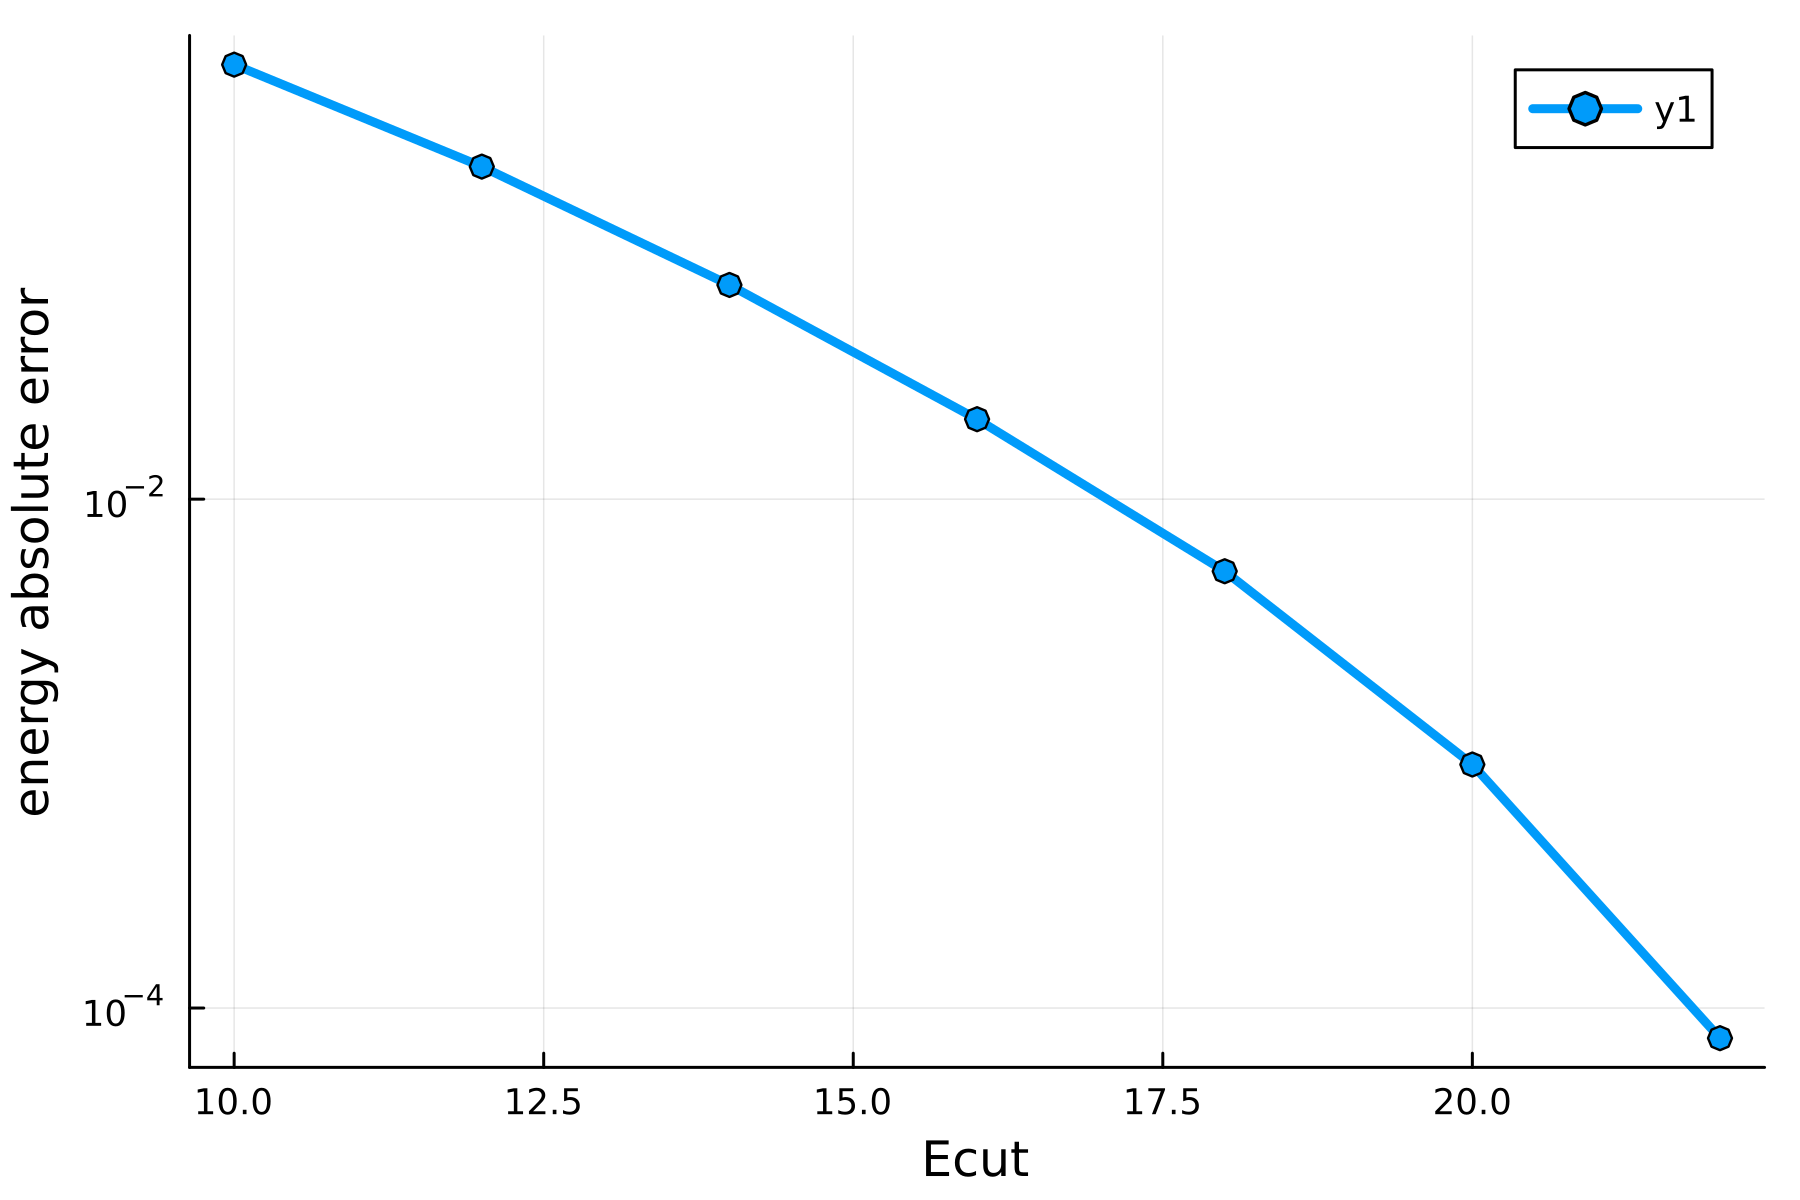

In [8]:
plot(result.Ecuts, result.errors, dpi=300, lw=3, m=:o, yaxis=:log,
     xlabel="Ecut", ylabel="energy absolute error")

## A more realistic example.
Repeating the above exercise for more realistic settings, namely …

In [9]:
tol   = 1e-4  # Tolerance to which we target to converge
nkpts = 1:20  # K-point range checked for convergence
Ecuts = 20:1:50;

…one obtains the following two plots for the convergence in `kpoints` and `Ecut`.

<img src="https://docs.dftk.org/stable/assets/convergence_study_kgrid.png" width=600 height=400 />
<img src="https://docs.dftk.org/stable/assets/convergence_study_ecut.png"  width=600 height=400 />